In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import torch
from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.utils.density_estimator import GPVarianceEstimator
from uncertaintylearning.utils.feature_generator import FeatureGenerator
from uncertaintylearning.utils.buffer import Buffer
from uncertaintylearning.models import EpistemicPredictor, MCDropout
from torch.utils.data import DataLoader, TensorDataset
from botorch.models import SingleTaskGP
from sklearn.linear_model import LinearRegression
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [3]:
device= torch.device("cpu")
dim=1
def oracle(x, noise=0):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
    return torch.where(torch.logical_and(x > 0.5, x < 1.5),
                       3./5 * (torch.sin(x) * torch.cos(5 * x) * torch.cos(22 * x) * -3 * torch.sin(7 * x) * torch.cos(19 * x) * 4 * torch.sin(11 * x)),
                       (2 * np.pi * x).sin()) + noise * m


In [166]:
def cheat_remove(xx, interval):
    ## xx is a 2 x 1 tensor
    return ood_x[torch.logical_or(ood_x > interval[1], ood_x < interval[0])].unsqueeze(-1)
    

In [184]:
def generate_data(n=1024, nood=32):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0)
        ood_x = torch.zeros(32, 1).uniform_(0.5, 1.5) # it's not really ood x, but just the x s that are in the spiked regions
        x_test = torch.linspace(-0.5, 2.5, 512).view(-1, 1)
        ood_x = torch.zeros(nood // 4, 1).uniform_(-0.25, 0.0)
        ood_x = torch.cat((ood_x, torch.zeros(nood // 4, 1).uniform_(2, 2.25)), 0)
        ood_x = torch.cat((ood_x, torch.zeros(nood, 1).uniform_(0.5, 1.5)), 0)
        y = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, x_test, y_test_true, ood_x, ood_y

x, y, x_test, y_test, ood_x, ood_y = generate_data(1024, 24)

# ood_x = cheat_remove(ood_x, (0.65, 0.7))
ood_y = oracle(ood_x)
X_train = torch.cat((x, ood_x))
Y_train = torch.cat((y, ood_y))
#n=100
#X_train = torch.zeros((n, 1)).uniform_(-0.25, 2.25)
#Y_train = oracle(X_train)

In [215]:
old_ood_x = ood_x
old_ood_y = ood_y

In [218]:
ood_x = cheat_remove(ood_x, (0.68, 0.7))
ood_y = oracle(ood_x)

In [219]:
ood_y = oracle(ood_x)
X_train = torch.cat((x, ood_x))
Y_train = torch.cat((y, ood_y))

In [220]:
model = SingleTaskGP(X_train, Y_train)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)
predictions = model(x_test)
mean = predictions.mean.detach()
std = predictions.stddev.detach()

/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:225: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [222]:
l2_errors = (mean - y_test.squeeze()) ** 2
gap = l2_errors - std ** 2

In [358]:
additional_x = torch.zeros(4, 1).uniform_(-0.5, -0.25)
additional_x = torch.cat((additional_x, torch.zeros((10, 1)).uniform_(0.5, 0.75)))
additional_x = torch.cat((additional_x, torch.zeros((10, 1)).uniform_(0.75, 1.5)))

additional_x = torch.cat((additional_x, torch.zeros(4, 1).uniform_(2.25, 2.5)))
additional_y = oracle(additional_x)
additional_z = (model(additional_x).mean.detach() - additional_y.squeeze()) ** 2

/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


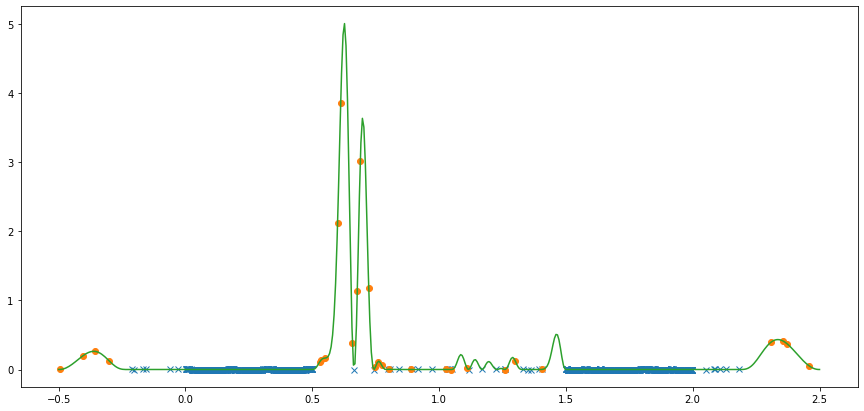

In [359]:
plt.figure(figsize=(15, 7))

Z_train = (model(X_train).mean.detach() - Y_train.squeeze()) ** 2
plt.plot(X_train, Z_train, 'x')
plt.plot(additional_x, additional_z, 'o')
plt.plot(x_test, l2_errors)

In [360]:
use_bit_feature = False

In [361]:

new_X_train = torch.cat((X_train, additional_x))
var_feature = model(new_X_train).stddev.detach().pow(2).unsqueeze(1)
var_feature = torch.empty((new_X_train.size(0), 0))
new_X_train = torch.cat((new_X_train, var_feature), dim=1)

if use_bit_feature:
    bit_feature = torch.cat((torch.zeros((X_train.size(0), 1)), torch.ones((additional_x.size(0), 1))))
    new_X_train = torch.cat((new_X_train, bit_feature), dim=1)
print(new_X_train.shape)
new_Z_train = torch.cat((Z_train, additional_z))

torch.Size([1087, 1])


/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:225: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [362]:
var_test = model(x_test).stddev.detach().pow(2).unsqueeze(1)
var_test = torch.empty((x_test.size(0), 0))
new_x_test = torch.cat((x_test, var_test), dim=1)
if use_bit_feature:
    bit_feature = (torch.cdist(x_test, X_train).min(1).values > 1e-2).to(torch.float32).unsqueeze(1)
    new_x_test = torch.cat((new_x_test, bit_feature), dim=1)
print(new_x_test.shape)

torch.Size([512, 1])


In [363]:
new_gp = SingleTaskGP(new_X_train, new_Z_train.unsqueeze(1))
new_mll = ExactMarginalLogLikelihood(new_gp.likelihood, new_gp)
_ = fit_gpytorch_model(new_mll)


In [364]:
predicted_l2 = new_gp(new_x_test).mean.detach()

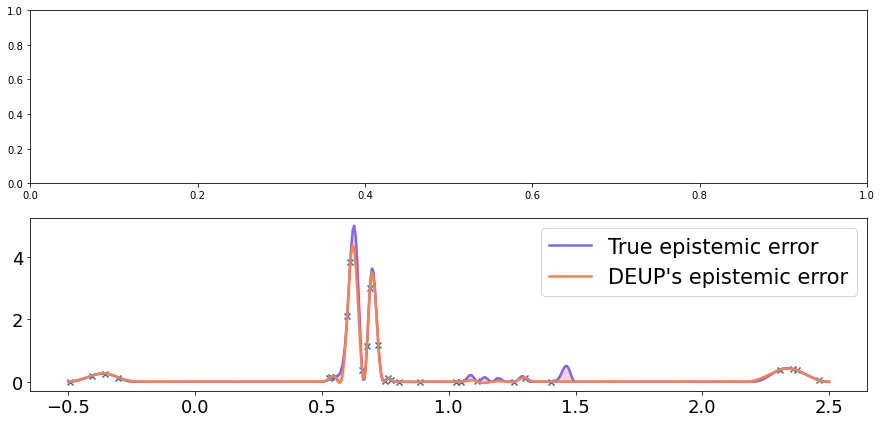

In [378]:
fig, axes = plt.subplots(2, 1, figsize=(15, 7))
new_gap = l2_errors - predicted_l2
axes[1].plot(x_test, l2_errors, linewidth=2.5, color='mediumslateblue', label='True epistemic error')
axes[1].plot(x_test, predicted_l2, linewidth=2.5, color='coral', label='DEUP\'s epistemic error')
axes[1].scatter(additional_x.squeeze(), additional_z, marker='x')
axes[1].fill_between(x_test.squeeze(), predicted_l2, predicted_l2 + new_gap * (new_gap > 0), color='crimson', alpha=.2)
axes[1].fill_between(x_test.squeeze(), predicted_l2 + new_gap * (new_gap < 0), predicted_l2, color='chartreuse', alpha=.2)
axes[1].tick_params(axis='both', which='major', labelsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)
axes[1].legend(prop={'size': 21})


<ipython-input-399-fc0711f6e360>:31: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('figs/gp_bias.pdf')
<ipython-input-399-fc0711f6e360>:31: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('figs/gp_bias.pdf')
/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwar

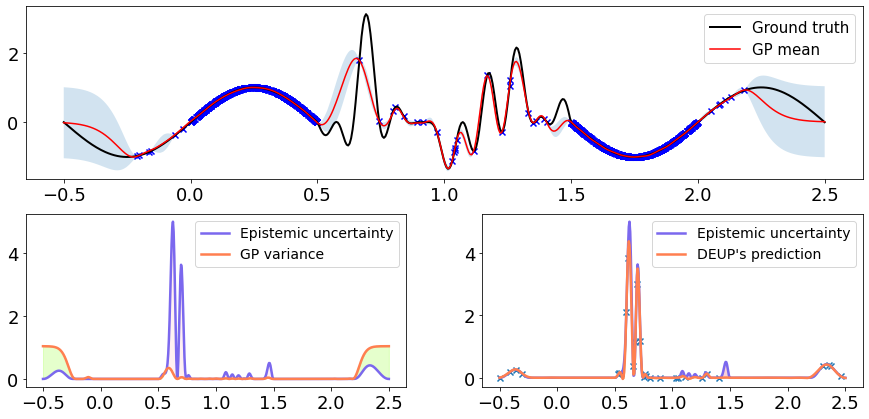

In [399]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize=(15, 7))
gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

ax0.plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
ax0.plot(x_test, mean, color='r', linewidth=1.5, label='GP mean')
ax0.fill_between(x_test.squeeze(), mean - std, mean + std, alpha=.2)
ax0.scatter(X_train, Y_train, color='b', marker='x')
ax0.legend(prop={'size': 15})
ax0.tick_params(axis='both', which='major', labelsize=18)

ax1.plot(x_test, l2_errors, linewidth=2.5, color='mediumslateblue', label='Epistemic uncertainty')
ax1.plot(x_test, std ** 2, linewidth=2.5, color='coral', label='GP variance')
ax1.fill_between(x_test.squeeze(), std ** 2, std ** 2 + gap * (gap > 0), color='lightpink', alpha=.2)
ax1.fill_between(x_test.squeeze(), std ** 2 + gap * (gap < 0), std ** 2, color='chartreuse', alpha=.2)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.legend(prop={'size': 14})

ax2.plot(x_test, l2_errors, linewidth=2.5, color='mediumslateblue', label='Epistemic uncertainty')
ax2.plot(x_test, predicted_l2, linewidth=2.5, color='coral', label='DEUP\'s prediction')
ax2.scatter(additional_x.squeeze(), additional_z, marker='x')
ax2.fill_between(x_test.squeeze(), predicted_l2, predicted_l2 + new_gap * (new_gap > 0), color='crimson', alpha=.2)
ax2.fill_between(x_test.squeeze(), predicted_l2 + new_gap * (new_gap < 0), predicted_l2, color='chartreuse', alpha=.2)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.legend(prop={'size': 14})

plt.savefig('figs/gp_bias.pdf')
plt.show()

## ALEATORIC NOISE AND ORACLE

In [54]:
noise = .8
def oracle(x, noise=noise):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
    return (torch.where(torch.logical_and(x > 0.5, x < 1.5),
                       3./5 * (torch.sin(x) * torch.cos(5 * x) * torch.cos(22 * x) * -3 * torch.sin(7 * x) * torch.cos(19 * x) * 4 * torch.sin(11 * x)),
                       (2 * np.pi * x).sin())
            + noise  * m)


In [103]:
def generate_data(n=1024, nood=32):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0)
        ood_x = torch.zeros(32, 1).uniform_(0.5, 1.5) # it's not really ood x, but just the x s that are in the spiked regions
        x_test = torch.linspace(-0.5, 2.5, 512).view(-1, 1)
        ood_x = torch.zeros(nood // 4, 1).uniform_(-0.25, 0.0)
        ood_x = torch.cat((ood_x, torch.zeros(nood // 4, 1).uniform_(2, 2.25)), 0)
        ood_x = torch.cat((ood_x, torch.zeros(nood, 1).uniform_(0.5, 1.5)), 0)
        y = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, x_test, y_test_true, ood_x, ood_y

x, y, x_test, y_test, ood_x, ood_y = generate_data(256, 24)

# ood_x = cheat_remove(ood_x, (0.65, 0.7))
ood_y = oracle(ood_x)
X_train = torch.cat((x, ood_x))
Y_train = torch.cat((y, ood_y))
#n=100
#X_train = torch.zeros((n, 1)).uniform_(-0.25, 2.25)
#Y_train = oracle(X_train)

In [104]:
model = SingleTaskGP(X_train, Y_train)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)
predictions = model(x_test)
mean = predictions.mean.detach()
std = predictions.stddev.detach()

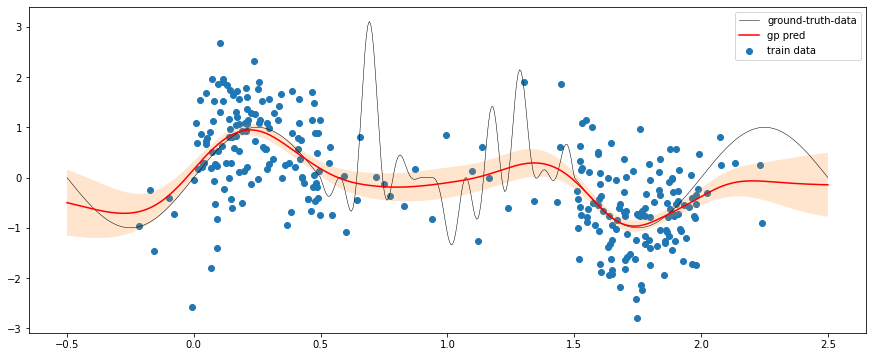

In [105]:
plt.figure(figsize=(15, 6))
# plt.scatter(x, y, color='b', label='easy data')
# plt.scatter(ood_x, ood_y, color='g', marker='x', label='hard data')
plt.scatter(X_train, Y_train, label='train data')
plt.plot(x_test, y_test, color='k', linewidth=.5, label='ground-truth-data')
plt.plot(x_test, mean, color='r', label='gp pred')
plt.fill_between(x_test.squeeze(), mean - std, mean + std, alpha=.2)
plt.legend()
plt.show()

In [106]:
l2_errors = (mean - y_test.squeeze()) ** 2
gap = l2_errors - std ** 2

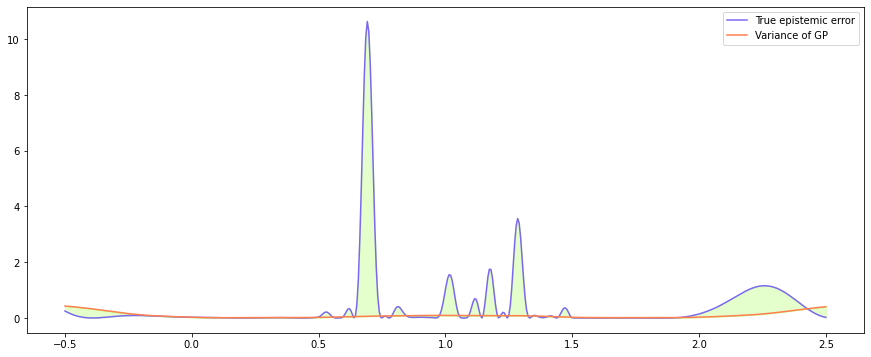

In [107]:
plt.figure(figsize=(15, 6))

plt.plot(x_test, l2_errors, linewidth=1.5, color='mediumslateblue', label='True epistemic error')
plt.plot(x_test, std ** 2, linewidth=1.5, color='coral', label='Variance of GP')
plt.fill_between(x_test.squeeze(), std ** 2, std ** 2 + gap * (gap > 0), color='chartreuse', alpha=.2)
plt.fill_between(x_test.squeeze(), std ** 2 + gap * (gap < 0), std ** 2, color='chartreuse', alpha=.2)
plt.legend()
plt.show()

In [121]:
additional_x = torch.zeros(4, 1).uniform_(-0.5, -0.25)
additional_x = torch.cat((additional_x, torch.zeros((25, 1)).uniform_(0.5, 1)))
additional_x = torch.cat((additional_x, torch.zeros((25, 1)).uniform_(1, 1.5)))

additional_x = torch.cat((additional_x, torch.zeros(4, 1).uniform_(2.25, 2.5)))
additional_y = oracle(additional_x)
additional_z = (model(additional_x).mean.detach() - additional_y.squeeze()) ** 2

/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


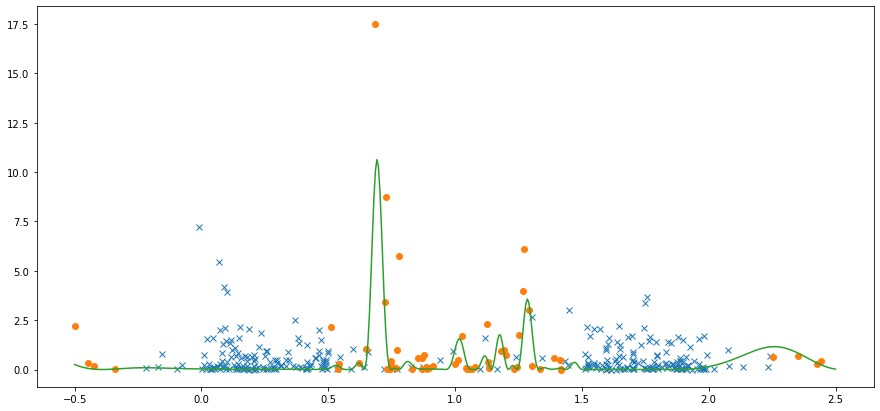

In [122]:
plt.figure(figsize=(15, 7))

Z_train = (model(X_train).mean.detach() - Y_train.squeeze()) ** 2
plt.plot(X_train, Z_train, 'x')
plt.plot(additional_x, additional_z, 'o')
plt.plot(x_test, l2_errors)

In [123]:
#aleatoric estimation
Y_train_2 = oracle(X_train)
aleatoric_targets = .5 * (Y_train - Y_train_2) ** 2



In [124]:
aleatoric_targets.mean()

tensor(0.6731)

In [125]:
from sklearn.linear_model import LinearRegression
aleatoric_gp = LinearRegression().fit(X_train, aleatoric_targets)

In [126]:
predicted_variance = torch.FloatTensor(aleatoric_gp.predict(x_test))
predicted_aleatoric = predicted_variance.squeeze()

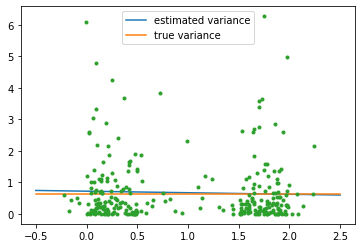

In [127]:
plt.plot(x_test, predicted_variance, label='estimated variance')
plt.plot(x_test, (noise * torch.ones(len(x_test))) ** 2, label='true variance')
plt.plot(X_train, aleatoric_targets, '.')
# plt.plot(x_test, predicted_aleatoric, label='estimated leatoric')
plt.legend()

In [128]:
use_bit_feature = False

In [129]:

new_X_train = torch.cat((X_train, additional_x))
var_feature = model(new_X_train).stddev.detach().pow(2).unsqueeze(1)
var_feature = torch.empty((new_X_train.size(0), 0))
new_X_train = torch.cat((new_X_train, var_feature), dim=1)

if use_bit_feature:
    bit_feature = torch.cat((torch.zeros((X_train.size(0), 1)), torch.ones((additional_x.size(0), 1))))
    new_X_train = torch.cat((new_X_train, bit_feature), dim=1)
print(new_X_train.shape)
new_Z_train = torch.cat((Z_train, additional_z))

torch.Size([350, 1])


In [130]:
new_Z_train.shape

torch.Size([350])

In [131]:
new_gp = SingleTaskGP(new_X_train, new_Z_train.unsqueeze(1))
new_mll = ExactMarginalLogLikelihood(new_gp.likelihood, new_gp)
_ = fit_gpytorch_model(new_mll)


In [132]:
predicted_epistemic = new_gp(x_test).mean.detach() - predicted_aleatoric

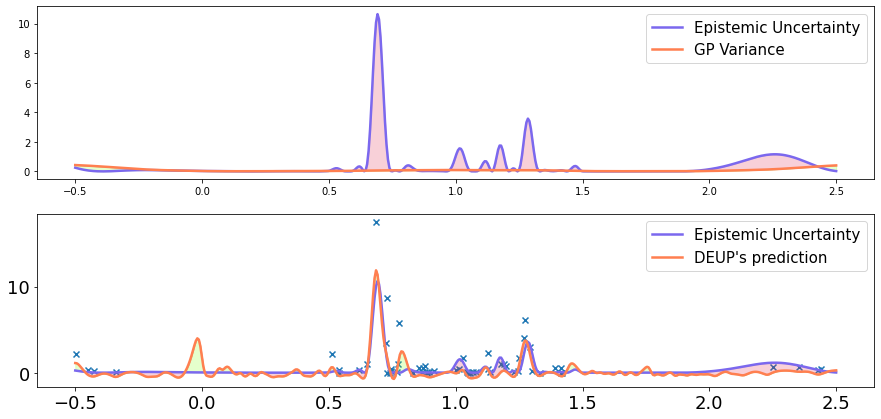

In [133]:
fig, axes = plt.subplots(2, 1, figsize=(15, 7))
new_gap = l2_errors - predicted_epistemic

axes[0].plot(x_test, l2_errors, linewidth=2.5, color='mediumslateblue', label='Epistemic Uncertainty')
axes[0].plot(x_test, std ** 2, linewidth=2.5, color='coral', label='GP Variance')
axes[0].fill_between(x_test.squeeze(), std ** 2, std ** 2 + gap * (gap > 0), color='crimson', alpha=.2)
axes[0].fill_between(x_test.squeeze(), std ** 2 + gap * (gap < 0), std ** 2, color='chartreuse', alpha=.2)
axes[0].legend(prop={'size': 15})


axes[1].plot(x_test, l2_errors, linewidth=2.5, color='mediumslateblue', label='Epistemic Uncertainty')
axes[1].plot(x_test, predicted_epistemic , linewidth=2.5, color='coral', label='DEUP\'s prediction')
axes[1].scatter(additional_x.squeeze(), additional_z, marker='x')
axes[1].fill_between(x_test.squeeze(), predicted_epistemic, predicted_epistemic + new_gap * (new_gap > 0), color='crimson', alpha=.2)
axes[1].fill_between(x_test.squeeze(), predicted_epistemic + new_gap * (new_gap < 0), predicted_epistemic, color='chartreuse', alpha=.2)
axes[1].tick_params(axis='both', which='major', labelsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)
axes[1].legend(prop={'size': 15})

plt.savefig('figs/gp_bias_alea.pdf')
plt.show()

<ipython-input-136-110afcfea0f3>:31: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('figs/gp_bias_alea.pdf')
<ipython-input-136-110afcfea0f3>:31: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('figs/gp_bias_alea.pdf')
/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout

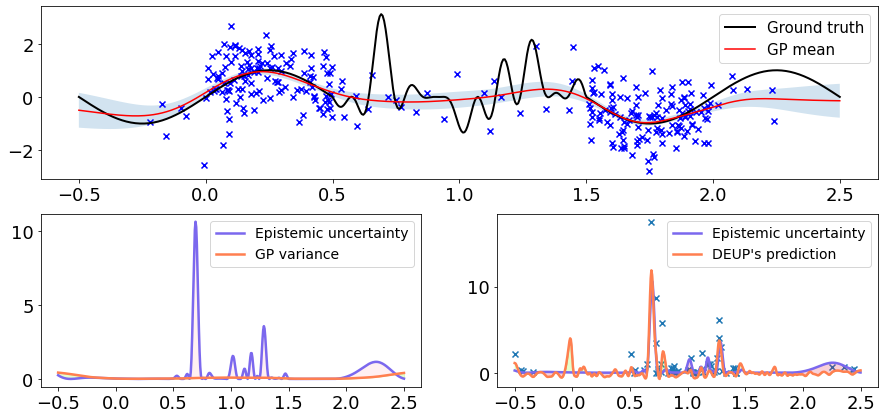

In [136]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize=(15, 7))
gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

ax0.plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
ax0.plot(x_test, mean, color='r', linewidth=1.5, label='GP mean')
ax0.fill_between(x_test.squeeze(), mean - std, mean + std, alpha=.2)
ax0.scatter(X_train, Y_train, color='b', marker='x')
ax0.legend(prop={'size': 15})
ax0.tick_params(axis='both', which='major', labelsize=18)

ax1.plot(x_test, l2_errors, linewidth=2.5, color='mediumslateblue', label='Epistemic uncertainty')
ax1.plot(x_test, std ** 2, linewidth=2.5, color='coral', label='GP variance')
ax1.fill_between(x_test.squeeze(), std ** 2, std ** 2 + gap * (gap > 0), color='lightpink', alpha=.2)
ax1.fill_between(x_test.squeeze(), std ** 2 + gap * (gap < 0), std ** 2, color='chartreuse', alpha=.2)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.legend(prop={'size': 14})

ax2.plot(x_test, l2_errors, linewidth=2.5, color='mediumslateblue', label='Epistemic uncertainty')
ax2.plot(x_test, predicted_epistemic, linewidth=2.5, color='coral', label='DEUP\'s prediction')
ax2.scatter(additional_x.squeeze(), additional_z, marker='x')
ax2.fill_between(x_test.squeeze(), predicted_epistemic, predicted_epistemic + new_gap * (new_gap > 0), color='crimson', alpha=.2)
ax2.fill_between(x_test.squeeze(), predicted_epistemic + new_gap * (new_gap < 0), predicted_epistemic, color='chartreuse', alpha=.2)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.legend(prop={'size': 14})

plt.savefig('figs/gp_bias_alea.pdf')
plt.show()